In [4]:
!pip install plotly
!pip install imbalanced-learn



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy import stats
import plotly.express as px
#from sklearn.preprocessing import LabelEncoder
#from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix, 
#                             ConfusionMatrixDisplay, roc_curve, auc)
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.inspection import permutation_importance
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

In [7]:
df = pd.read_csv('online_shoppers_intention.csv')
df.head(10)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
5,0,0.0,0,0.0,19,154.216667,0.015789,0.024561,0.0,0.0,Feb,2,2,1,3,Returning_Visitor,False,False
6,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.4,Feb,2,4,3,3,Returning_Visitor,False,False
7,1,0.0,0,0.0,0,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,2,1,5,Returning_Visitor,True,False
8,0,0.0,0,0.0,2,37.000000,0.000000,0.100000,0.0,0.8,Feb,2,2,2,3,Returning_Visitor,False,False
9,0,0.0,0,0.0,3,738.000000,0.000000,0.022222,0.0,0.4,Feb,2,4,1,2,Returning_Visitor,False,False


Описание признаков:
Administrative — число просмотренных страниц административного раздела
Administrative_Duration — суммарное время (секунды) на административных страницах
Informational — количество открытых информационных страниц
Informational_Duration — продолжительность пребывания (секунды) на информационных страницах
ProductRelated — объём посещений страниц с продуктами
ProductRelated_Duration — время в секундах, потраченное на продуктовые страницы
BounceRates — доля посетителей, ушедших после одной страницы (отскок)
ExitRates — коэффициент завершения сессий на конкретной странице
PageValues — средняя значимость страницы для покупки
SpecialDay — степень близости визита к праздничной дате (0–1)
Month — месяц активности на сайте
OperatingSystems — ОС устройства посетителя
Browser — используемый браузер
Region — регион происхождения пользователя
TrafficType — тип трафика (канал привлечения)
VisitorType — категория посетителя (новичок/повторный)
Weekend — визит в выходной день (да/нет)
Revenue — цель: факт совершения покупки (бинарная)

В этой лабораторной таргетом будет Revenue

Посомтрим типы данных в таблице

In [8]:
print(df.shape)
print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df.duplicated().sum())

(12330, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficTyp

12330 строк, 18 столбцов, пропусков нет, 125 дубликатов - нужно их удалить

In [9]:
df.drop_duplicates(inplace=True)
print(f'Новая форма: {df.shape}')

Новая форма: (12205, 18)


Поиск выбросов

In [10]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).sum()
print(outliers.sort_values(ascending=False))


Browser                    4322
PageValues                 2730
Informational              2631
Informational_Duration     2405
TrafficType                2084
BounceRates                1428
ExitRates                  1325
SpecialDay                 1249
Administrative_Duration    1149
ProductRelated             1007
ProductRelated_Duration     951
Region                      505
Administrative              404
OperatingSystems            107
dtype: int64


Вижу много выбросов в Browser, PageValues, Informational, Informational_Duration. Удалять не стоит, тк потеряем много информации. Позже, скорее всего, пойду через логарифмирование.

Визуализация распределений признаков

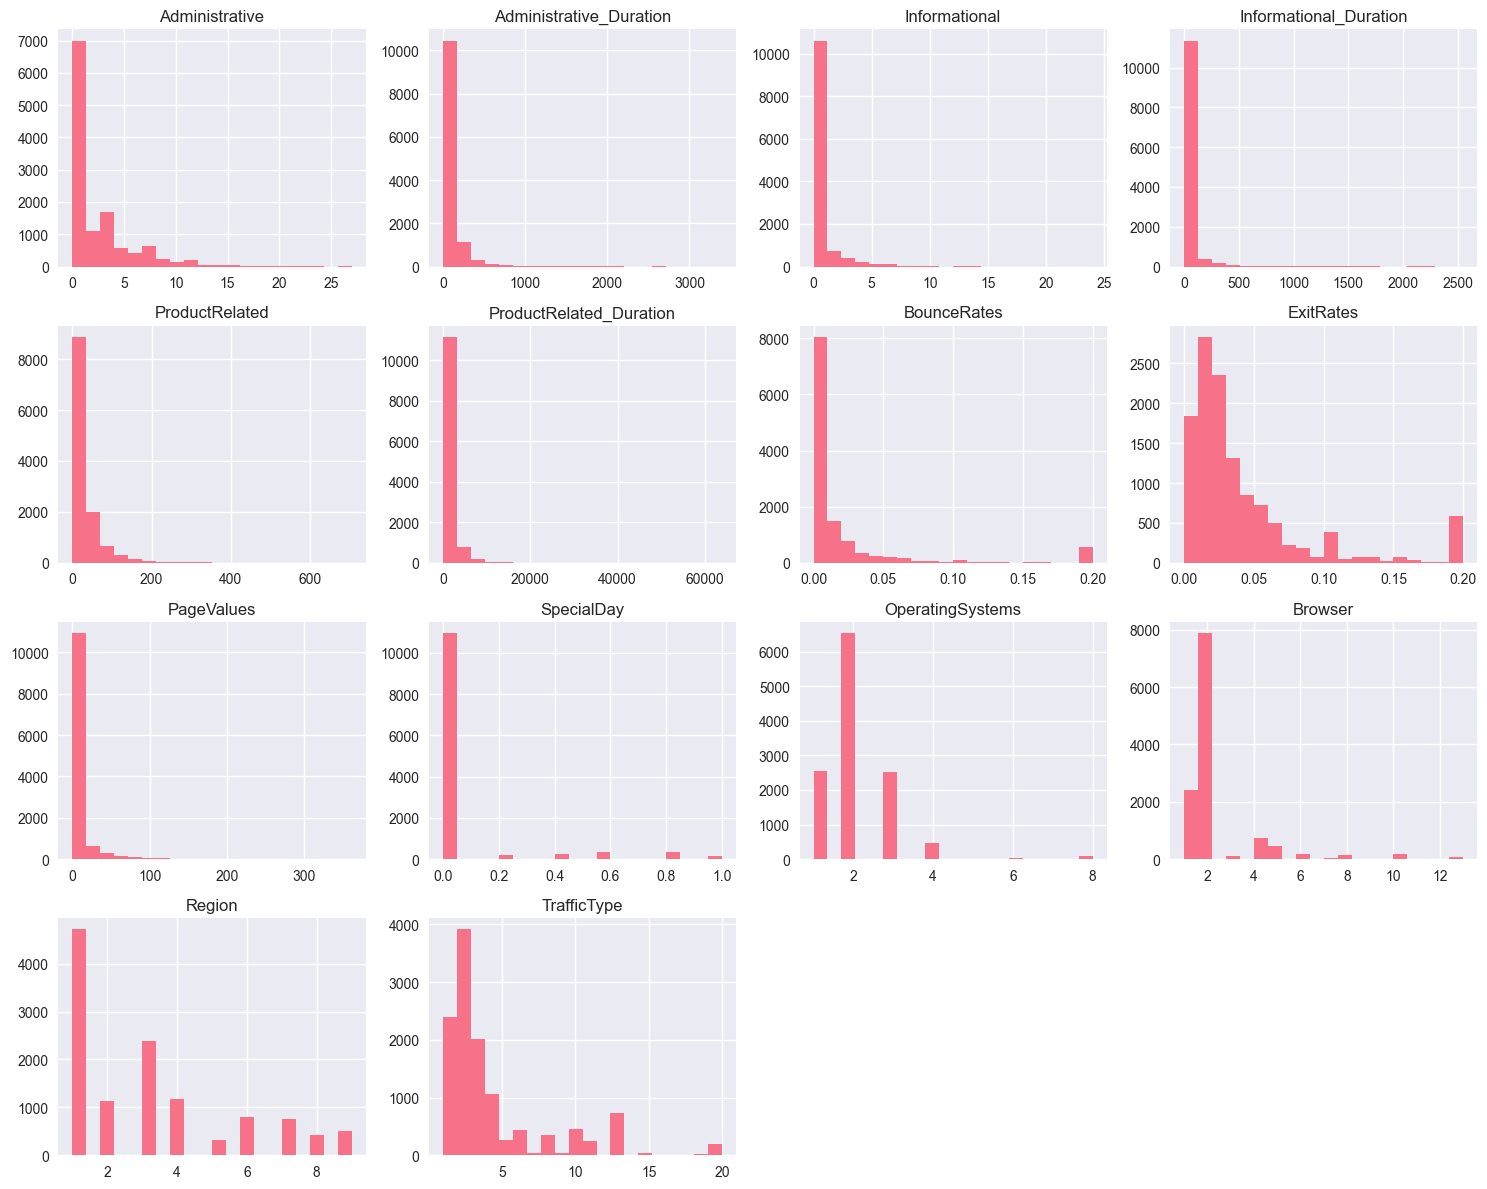

In [11]:
df.hist(bins=20, figsize=(15,12))
plt.tight_layout()
plt.show()

сильный правый скос у признаков Durations,PageValues,ProductRelated - можно будет применить нормализацию

По корреляции

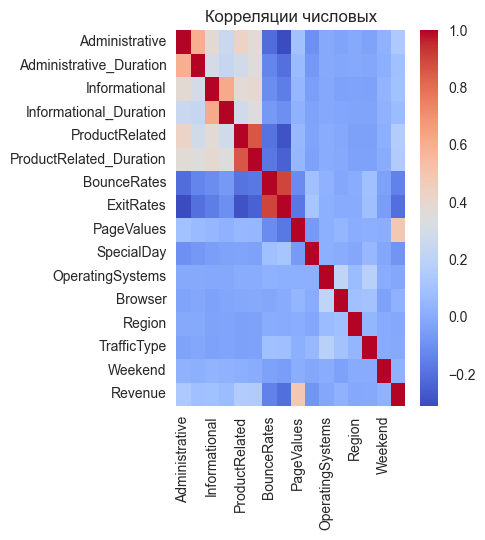

In [12]:
plt.subplot(1,2,2)
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title('Корреляции числовых')
plt.tight_layout()
plt.show()

По тепловой матрице видно, что наибольшая корреляция Revanue с PageValues
Еще кандидат: ProductRelated_Duration

Проверим дисбаланс классов Revenue

Revenue
False    0.843671
True     0.156329
Name: proportion, dtype: float64


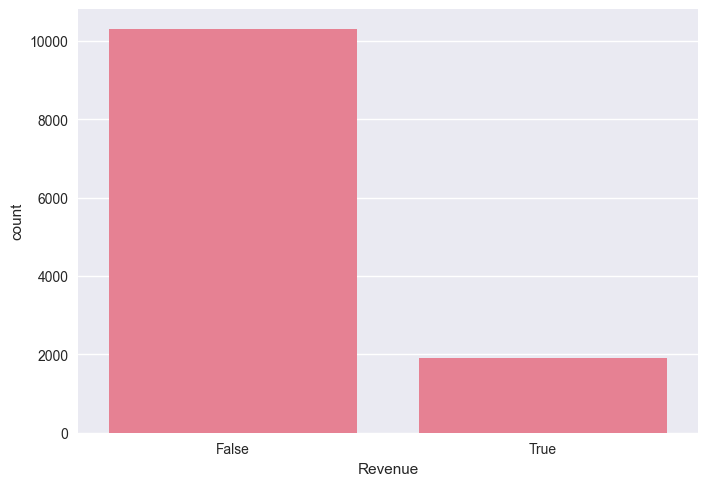

In [13]:
print(df['Revenue'].value_counts(normalize=True))
sns.countplot(data=df, x='Revenue');
plt.savefig('revenue_balance.png')
plt.show()

Собственно 84.4% сессий без покупки (False), 15.6% с покупкой (True)

У нас две категориальные фичи Month VisitorType (новичок/бывалый)
Сделаем кодировку

In [21]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['Month', 'VisitorType']
le_month = LabelEncoder()
df['Month'] = le_month.fit_transform(df['Month'])
le_visitor = LabelEncoder()
df['VisitorType'] = le_visitor.fit_transform(df['VisitorType'].astype(str))

print(df[cat_cols].head())
print(df.dtypes)


   Month  VisitorType
0      2            2
1      2            2
2      2            2
3      2            2
4      2            2
Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                        int64
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                  int64
Weekend                       bool
Revenue                       bool
dtype: object


балансировка для revenue (smote)

In [22]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df.drop('Revenue', axis=1)
y = df['Revenue'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

smote = SMOTE(sampling_strategy=0.25, random_state=42)  # True до 25% от False
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print('До SMOTE:', pd.Series(y_train).value_counts(normalize=True))
print('После:', pd.Series(y_train_sm).value_counts(normalize=True))


До SMOTE: Revenue
0    0.843712
1    0.156288
Name: proportion, dtype: float64
После: Revenue
0    0.800039
1    0.199961
Name: proportion, dtype: float64


smote увеличил долю покупок (True) с 15.6% до 20% в train

Важность фич

                       feat       imp
8                PageValues  0.161819
7                 ExitRates  0.009095
0            Administrative  0.008193
1   Administrative_Duration  0.007415
4            ProductRelated  0.005408
10                    Month  0.004465
6               BounceRates  0.002212
3    Informational_Duration  0.001639
11         OperatingSystems  0.001147
5   ProductRelated_Duration  0.001147


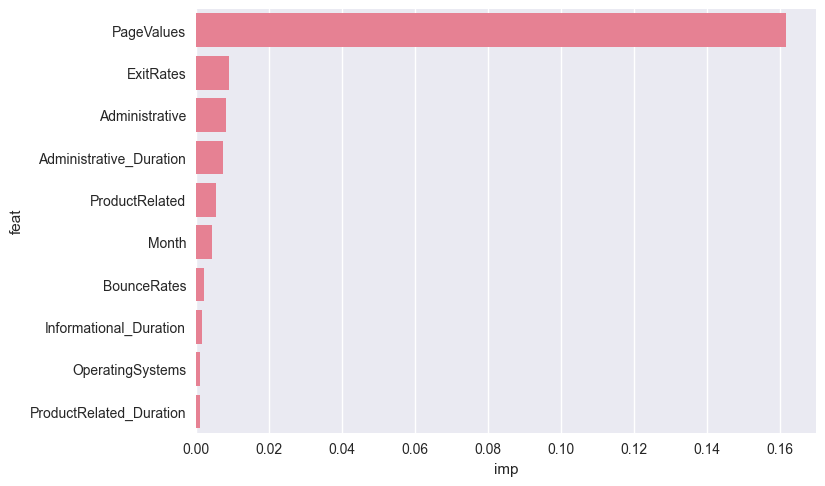

In [23]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_sm, y_train_sm)
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

imp_df = pd.DataFrame({'feat':X.columns, 'imp':perm.importances_mean}).sort_values('imp', ascending=False)
print(imp_df.head(10))
sns.barplot(data=imp_df.head(10), x='imp', y='feat');
plt.show()

Собственно подтвердил, больший импакт вносит PageValues
ExitRates,Admin,ProductRelated,Month тоже возьмем за значимые

### Models

In [ ]:
Логистическая регрессия

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import GradientBoostingClassifier

In [28]:
pipe_lr = Pipeline([('scale', StandardScaler()), ('lr', LogisticRegression(random_state=42))])
gs_lr = GridSearchCV(pipe_lr, {'lr__C': [0.01, 0.1, 1, 10]}, cv=StratifiedKFold(5, shuffle=True, random_state=42), scoring='roc_auc')
gs_lr.fit(X_train_sm, y_train_sm)
print(f'LR Best: CV ROC {gs_lr.best_score_:.3f}')
print(f'Test ROC: {roc_auc_score(y_test, gs_lr.best_estimator_.predict_proba(X_test)[:,1]):.3f}')

LR Best: CV ROC 0.888
Test ROC: 0.890


Градиентный бустинг

In [29]:
gs_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                     {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]}, 
                     cv=StratifiedKFold(5, shuffle=True, random_state=42), scoring='roc_auc', n_jobs=-1)
gs_gb.fit(X_train_sm, y_train_sm)
print(f'GB Best: CV ROC {gs_gb.best_score_:.3f}')
print(f'Test ROC: {roc_auc_score(y_test, gs_gb.best_estimator_.predict_proba(X_test)[:,1]):.3f}')

GB Best: CV ROC 0.941
Test ROC: 0.932


как-то долго обрабатывал, по сравнению с предыдущим, но выдал лучше результат

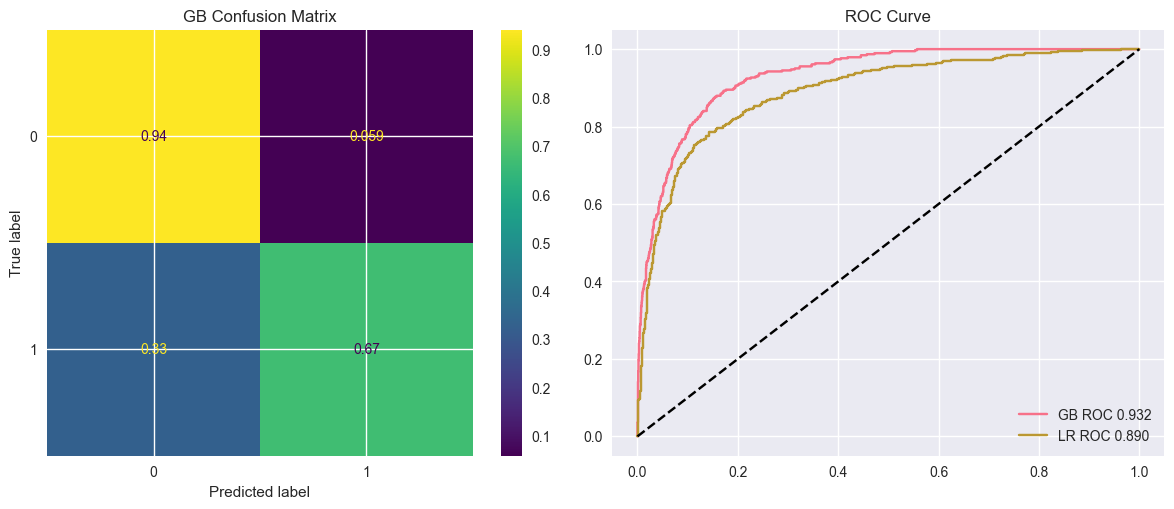

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, roc_auc_score

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

y_pred_gb = gs_gb.best_estimator_.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb, normalize='true', ax=axes[0])
axes[0].set_title('GB Confusion Matrix')

y_proba_gb = gs_gb.best_estimator_.predict_proba(X_test)[:,1]
y_proba_lr = gs_lr.best_estimator_.predict_proba(X_test)[:,1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
axes[1].plot(fpr_gb, tpr_gb, label=f'GB ROC {roc_auc_score(y_test, y_proba_gb):.3f}')
axes[1].plot(fpr_lr, tpr_lr, label=f'LR ROC {roc_auc_score(y_test, y_proba_lr):.3f}')
axes[1].plot([0,1], [0,1], 'k--')
axes[1].legend()
axes[1].set_title('ROC Curve')

plt.tight_layout()
plt.show()

хочу еще посмотреть с random forest


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

gs_rf = GridSearchCV(RandomForestClassifier(random_state=42), 
                     {'n_estimators': [100, 200], 'max_depth': [10, None]}, 
                     cv=StratifiedKFold(5, shuffle=True, random_state=42), scoring='roc_auc', n_jobs=-1)
gs_rf.fit(X_train_sm, y_train_sm)
print(f'RF Best: CV ROC {gs_rf.best_score_:.3f}')
print(f'Test ROC: {roc_auc_score(y_test, gs_rf.best_estimator_.predict_proba(X_test)[:,1]):.3f}')


RF Best: CV ROC 0.943
Test ROC: 0.927


Результат приближен к GB

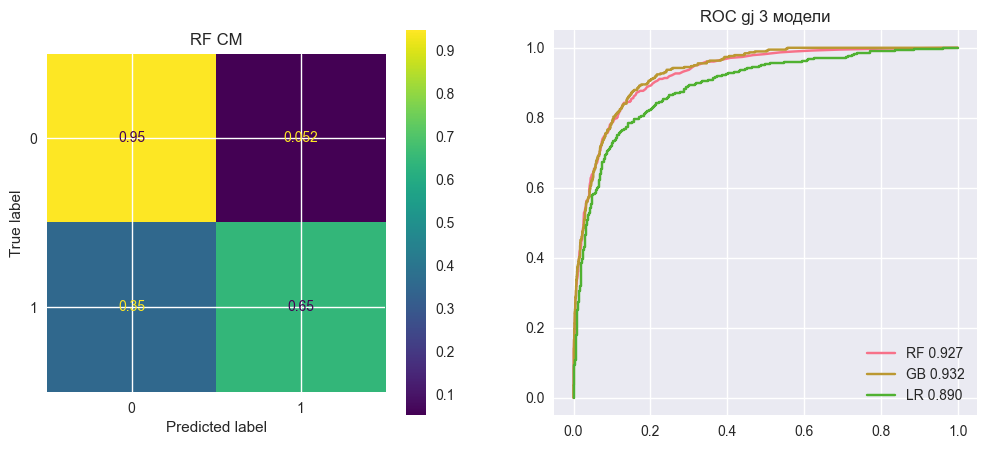

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ConfusionMatrixDisplay.from_predictions(y_test, gs_rf.best_estimator_.predict(X_test), normalize='true', ax=ax1)
ax1.set_title('RF CM')

y_proba_rf = gs_rf.best_estimator_.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
ax2.plot(fpr_rf, tpr_rf, label=f'RF 0.927')
ax2.plot(fpr_gb, tpr_gb, label='GB 0.932')
ax2.plot(fpr_lr, tpr_lr, label='LR 0.890')
ax2.legend()
ax2.set_title('ROC gj 3 модели')
plt.show()


По итогу GB лучше RF 0.927, LR 0.890, Recall True GB 67%

In [ ]:
print('Доля предсказанных покупок:')
print(f'GB: {gs_gb.best_estimator_.predict(X_test).mean():.1%}')
print(f'RF: {gs_rf.best_estimator_.predict(X_test).mean():.1%}')
print(f'LR: {gs_lr.best_estimator_.predict(X_test).mean():.1%}')

print('\nСредняя вероятность покупки:')
print(f'GB: {gs_gb.best_estimator_.predict_proba(X_test)[:,1].mean():.3f}')
print(f'RF: {gs_rf.best_estimator_.predict_proba(X_test)[:,1].mean():.3f}')
print(f'LR: {gs_lr.best_estimator_.predict_proba(X_test)[:,1].mean():.3f}')


Доля предсказанных покупок (threshold 0.5):
GB: 15.4%
RF: 14.5%
LR: 9.7%

Средняя вероятность покупки:
GB: 0.175
RF: 0.174
LR: 0.186
